In [88]:
# Handle all includes
%load_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spatz.utils.preprocess import preprocess_file
from spatz.simulation import Simulation, UniformTimeSteps


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Do preprocessing
PATH = "data/simulations"
TMP = f"{PATH}/temp"
FILE = "40km"

if os.path.isdir(TMP):
    shutil.rmtree(TMP)
os.mkdir(TMP)

df = preprocess_file(f"{PATH}/{FILE}.txt")
df.to_csv(f"{TMP}/{FILE}.csv")


In [90]:
# Create simulation objects
timesteps = UniformTimeSteps(0.1, mu=0, sigma=0, delay_only=True)
simulation = Simulation(timesteps)

In [91]:
from spatz.sensors.antenna.pathloss import AntennaPathloss
from spatz.sensors.antenna.tx_gain import AntennaTxGain
from spatz.sensors.antenna.constants import STAHR_LORA_FREQ, STAHR_GS_OFFSET

alt = simulation.add_observer(['altitude'])
fspl_gs = simulation.add_sensor(AntennaPathloss,frequency=STAHR_LORA_FREQ,rx_antenna_offset=STAHR_GS_OFFSET)

tx_gain = simulation.add_sensor(AntennaTxGain,gain_pattern_path=f"data/gain_pattern/farfield_tx_aisler_v1.txt",rx_antenna_offset = STAHR_GS_OFFSET)

simulation.load(f"{TMP}/{FILE}.csv")
logger = simulation.get_logger()

Processed 65160 lines in 0.3s.
Used 65160 lines due to step size


In [92]:
# Run simulation
for step, t, dt in simulation.run(verbose=True):
    fspl_gs()
    tx_gain()
    alt()

df = logger.get_dataframe()

100%|█████████▉| 197.89999999999304/197.96503111341 [00:06<00:00, 29.46it/s]


In [93]:
df["general/altitude"].max()
df

time antenna/pathloss/pad_distance antenna/pathloss/gs_distance  \
0       0.1                   2393.642403                  2393.642403   
1       0.2                   2393.635673                  2393.635673   
2       0.3                   2393.630009                  2393.630009   
3       0.4                   2393.633015                  2393.633015   
4       0.5                   2393.648731                  2393.648731   
...     ...                           ...                          ...   
1974  197.5                  36965.892649                 36965.892649   
1975  197.6                  36977.682744                 36977.682744   
1976  197.7                  36989.474675                 36989.474675   
1977  197.8                  37001.267964                 37001.267964   
1978  197.9                  37013.062286                 37013.062286   

     antenna/pathloss/out antenna/tx_gain/rocket_x antenna/tx_gain/rocket_y  \
0               107.81229                      0.0                 0.171335   
1              107.812266                      0.0                 0.171335   
2              107.812245                     -0.0                 0.171335   
3              107.812256                     -0.0                 0.171335   
4              107.812313                     -0.0                 0.171335   
...                   ...                      ...                      ...   
1974           131.587129                 0.005339                 0.199508   
1975           131.589899                 0.005338                 0.199181   
1976           131.592668                 0.005337                 0.198854   
1977           131.595437                 0.005336                 0.198527   
1978           131.598205                 0.005335                 0.198199   

     antenna/tx_gain/rocket_z antenna/tx_gain/pos_x antenna/tx_gain/pos_y  \
0                    0.985213              0.774045               0.62666   
1                    0.985213              0.774038              0.626662   
2                    0.985213               0.77402              0.626663   
3                    0.985213              0.773985              0.626662   
4                    0.985213              0.773932              0.626658   
...                       ...                   ...                   ...   
1974                -0.979882             -0.965728              0.038192   
1975                -0.979948             -0.965398              0.038184   
1976                -0.980015             -0.965067              0.038177   
1977                -0.980081             -0.964737              0.038169   
1978                -0.980147             -0.964406              0.038162   

     antenna/tx_gain/pos_z antenna/tx_gain/theta antenna/tx_gain/out  \
0                 0.090286            101.321859            4.214389   
1                 0.090333            101.324573            4.214139   
2                 0.090481            101.333096            4.213355   
3                 0.090782            101.350431             4.21176   
4                 0.091262             101.37803            4.209221   
...                    ...                   ...                 ...   
1974             -0.256731            104.716086            3.878095   
1975             -0.257971            104.788403            3.870429   
1976             -0.259205            104.860455            3.862792   
1977             -0.260435            104.932242            3.855182   
1978             -0.261659            105.003766            3.847586   

     general/altitude  
0          318.993506  
1          319.087226  
2          319.413466  
3          320.094623  
4          321.195802  
...               ...  
1974        201.53925  
1975       157.943233  
1976       114.487215  
1977        71.171197  
1978         27.99477  

[1979 rows x 13 columns]

132.97536657811125


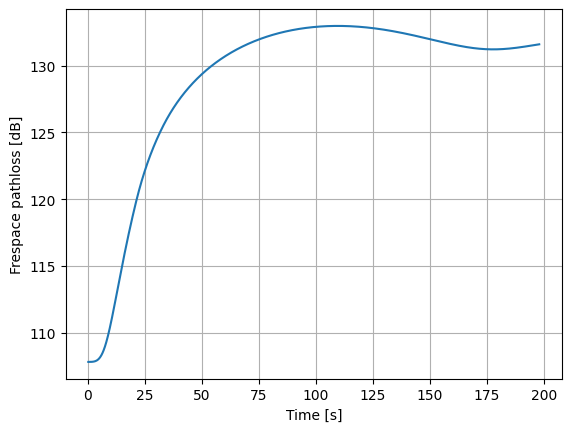

In [94]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/out'][1:], label='FSPL')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")

print(np.max(df['antenna/pathloss/out'][1:]))

43372.36295531341


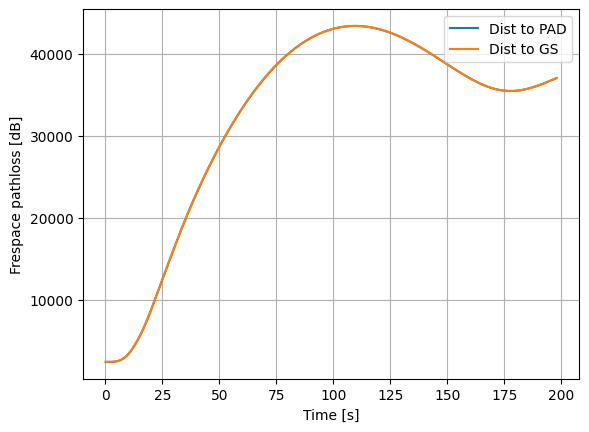

In [95]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/pathloss/pad_distance'][1:], label='Dist to PAD')
plt.plot(df['time'][1:], df['antenna/pathloss/gs_distance'][1:], label='Dist to GS')
plt.ylabel("Frespace pathloss [dB]")
plt.xlabel("Time [s]")
plt.legend()

print(np.max(df['antenna/pathloss/gs_distance'][1:]))

-8.061355822543295


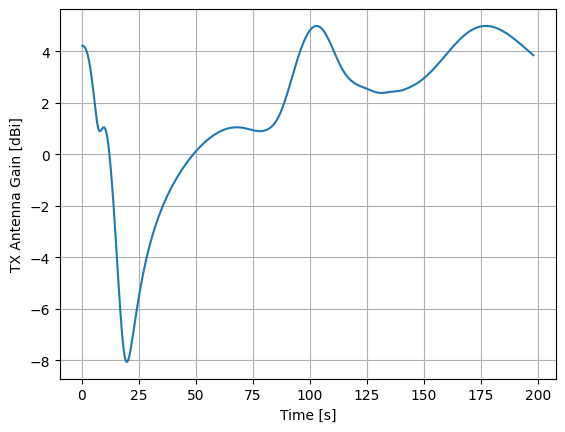

In [98]:
plt.grid()
plt.plot(df['time'][1:], df['antenna/tx_gain/out'][1:], label='FSPL')
plt.ylabel("TX Antenna Gain [dBi]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/tx_gain/out'][1:]))

-110.36486375494266


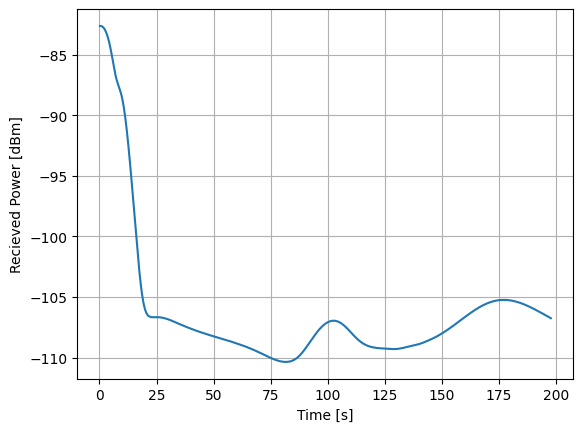

In [97]:
# Calculate recieved power
# Assumptions:  3 dB polarization loss
#               25 dBm output power per channel
#               16 dBi antenna rx gain
#               -6 dB on reciever side


df["antenna/power_rx"] = 20+df["antenna/tx_gain/out"] - df["antenna/pathloss/out"] - 3 + 10 - 6 
plt.grid()
plt.plot(df['time'][1:], df['antenna/power_rx'][1:], label='FSPL')
plt.ylabel("Recieved Power [dBm]")
plt.xlabel("Time [s]")

print(np.min(df['antenna/power_rx'][1:]))